## Simulation Approach

- 1_000_000 rounds for statisctical significane
- Fixed 95% RTP target
- Dynamic house edge adjustment to maintain RTP

## Imports

In [1]:
import json
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore

## Implementation

In [2]:
# Import json parsheet
with open('aviator-parsheet.json') as f:
    parsheet = json.load(f)

In [3]:
# game settings
game_id = parsheet['id']
target_rtp = parsheet['target_rtp']
house_edge = 1 - target_rtp
bet = parsheet['bets'][5]
cashout = parsheet['sample_cashout']
max_multiplier = parsheet['multipliers'][-1]

In [4]:
def generate_crash_point(house_edge=0.05, max_multiplier=100):
    """
    Generate Crash Point via exponential decay function

    param:
        house_edge: decimal format (house earning)
        max_multiplier: max multiplier assigned to parsheet

    return:
        crash_point: value in between min-max multiplier
    """
    U = np.random.random()
    return min((1 - house_edge) / U, max_multiplier)

In [5]:
# sample crash point
crash_p = generate_crash_point()
crash_p

2.152402346209347

In [6]:
def single_run(bet, n_rounds=1):
    """
    Simulate single run
    """
    crash_point = round(generate_crash_point(),2)   # generate a crashpoint
    cashout = float(input("Enter Cashout Multiplier: "))
    
    if cashout <= crash_point:
        payout = bet * cashout
    else:
        payout = 0

    return print(f'\nCrash Point: {crash_point}\nBet Amount: {bet}\nCashout At: {cashout}\nPayout Given: {payout}')

out = single_run(bet=10)
out

Enter Cashout Multiplier:  5



Crash Point: 7.7
Bet Amount: 10
Cashout At: 5.0
Payout Given: 50.0


In [8]:
def simulation(bet, cashout, house_edge, target_rtp, n_rounds=1_000_000):
    results = []
    total_bet = 0.0
    total_payout = 0.0

    for _ in tqdm(range(n_rounds)):

        cashout_point = np.random.choice(cashout)
        crash_point = generate_crash_point()

        if cashout_point <= crash_point:
            payout = bet * cashout_point
        else:
            payout = 0.0

        results.append({
            'crash_point': round(crash_point,3),
            'cashout': round(cashout_point, 3),
            'payout': payout
        })
        total_bet += bet
        total_payout += payout

    return pd.DataFrame(results)

# Run Simulation
results = simulation(bet, cashout, house_edge=house_edge, target_rtp=target_rtp, n_rounds=1_000_000)
print(f"Final RTP: {results['payout'].sum() / len(results):.4f}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:08<00:00, 114230.12it/s]


Final RTP: 0.9489


In [15]:
rtp = results['payout'].sum() / len(results)
print(f'RTP over 1M: {round(float(rtp), 4) * 100}%')

RTP over 1M simulation: 94.89%


## Analysis

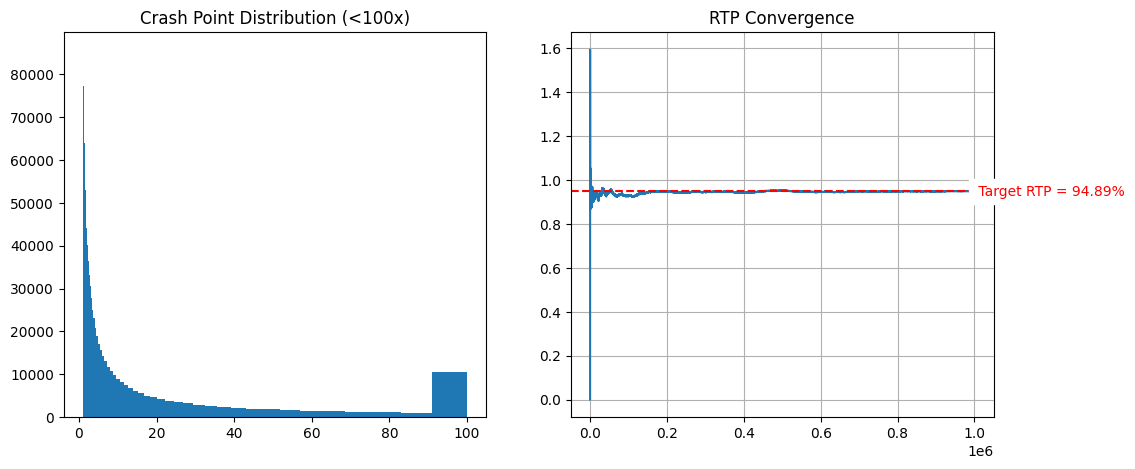

In [16]:
# Crash point distribution
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
bins = np.logspace(0, np.log10(100), 50)  # 50 bins spaced logarithmically to avoid overflow bin
plt.hist(results['crash_point'], bins=bins)
plt.title("Crash Point Distribution (<100x)")

# RTP convergence
cumulative_rtp = results['payout'].cumsum() / (results.index + 1)
plt.subplot(1,2,2)
cumulative_rtp.plot(label='Actual RTP')
plt.axhline(rtp, color='r', linestyle='--', label='Target RTP')
plt.text(x=len(results), y=rtp, 
         s=f' Target RTP = {rtp:.2%}',
         color='r',
         va='center',
         ha='left',
         backgroundcolor='white')
plt.grid(True)
plt.title("RTP Convergence")
plt.show()

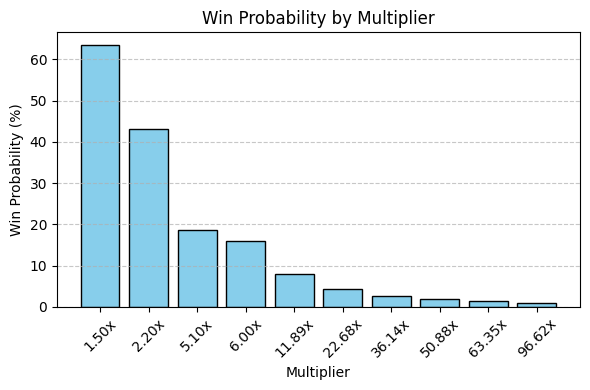

In [17]:
key_multipliers = cashout
percentiles = [percentileofscore(results['crash_point'], x) for x in key_multipliers]

plt.figure(figsize=(6, 4))
plt.bar(range(len(key_multipliers)), 100 - np.array(percentiles), color='skyblue', edgecolor='black')
plt.xticks(range(len(key_multipliers)), [f'{x:.2f}x' for x in key_multipliers], rotation=45)
plt.title('Win Probability by Multiplier')
plt.ylabel('Win Probability (%)')
plt.xlabel('Multiplier')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Multipliers Values

for adding multipliers or changing multipliers value given geospace and linspace

In [18]:
# creating multiplier values
multipliers = np.unique(np.concatenate([
    np.linspace(1.5, 50, 15),      # High precision for common targets
    np.geomspace(52, 100, 20),       # Moderate precision
    np.geomspace(100, 200, 10),     # Lower precision for high multipliers
    [500, 1000]     # Rare jackpots
]))

In [19]:
out = [float(round(multipliers[m], 2)) for m in range(len(multipliers))]
print(out)

[1.5, 4.96, 8.43, 11.89, 15.36, 18.82, 22.29, 25.75, 29.21, 32.68, 36.14, 39.61, 43.07, 46.54, 50.0, 52.0, 53.82, 55.71, 57.66, 59.67, 61.76, 63.93, 66.17, 68.48, 70.88, 73.36, 75.93, 78.59, 81.34, 84.19, 87.14, 90.19, 93.35, 96.62, 100.0, 108.01, 116.65, 125.99, 136.08, 146.97, 158.74, 171.45, 185.17, 200.0, 500.0, 1000.0]


## Probabilities

In [36]:
mul = out
prob = []

for m in range(len(mul)):
    p = (1 - house_edge) / mul[m]
    prob.append(round(p, 5))

In [37]:
print(prob)

[0.63333, 0.19153, 0.11269, 0.0799, 0.06185, 0.05048, 0.04262, 0.03689, 0.03252, 0.02907, 0.02629, 0.02398, 0.02206, 0.02041, 0.019, 0.01827, 0.01765, 0.01705, 0.01648, 0.01592, 0.01538, 0.01486, 0.01436, 0.01387, 0.0134, 0.01295, 0.01251, 0.01209, 0.01168, 0.01128, 0.0109, 0.01053, 0.01018, 0.00983, 0.0095, 0.0088, 0.00814, 0.00754, 0.00698, 0.00646, 0.00598, 0.00554, 0.00513, 0.00475, 0.0019, 0.00095]


## Data 

`results` => will be stored in `results.csv`

In [38]:
results.to_csv('results.csv', index=False)

In [3]:
!jupyter nbconvert --to script Practical-Copy1.ipynb

[NbConvertApp] Converting notebook Practical-Copy1.ipynb to script
[NbConvertApp] Writing 3696 bytes to Practical-Copy1.py
